In [ ]:
from math import sqrt 
import datetime as dt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import time
import json
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, accuracy_score
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K
from imblearn.combine import SMOTEENN

%matplotlib inline

#Funciones

In [ ]:
def helada(row):
  if row['Y'] <= 0:
    return 0
  else: 
    return 1 

#Parámetros

In [ ]:
look_back=18
col=['LowTemp','OutHum','DewPt']
colnames= []

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Preprocesamiento

In [ ]:
for i in range(look_back): 
  for s in col:
    colnames.append(s+str(i+1))

cantCaract= len(colnames)

colnames.append("Y")
colnames_remuestreo= colnames.copy()
colnames.append("DateTime")

In [ ]:
df_inta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosINTA_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_inta['DateTime'] = pd.to_datetime(df_inta['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_test= df_inta.sort_values(by='DateTime')

In [ ]:
df_sftrain= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_DewPt_Smoteen_vent3_hor3_train.csv', usecols=colnames_remuestreo,low_memory=False)
df_sfval= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_DewPt_Smoteen_vent3_hor3_val.csv', usecols=colnames_remuestreo,low_memory=False)

In [ ]:
col_num= colnames[:cantCaract+1]
for c in col_num:
  df_inta[c].mask(df_inta[c] == '---',0,inplace=True)
  df_inta[c]= pd.to_numeric(df_inta[c])

In [ ]:
xtrain= df_sftrain.iloc[:,0:cantCaract]
ytrain= df_sftrain.loc[:,'Y']
xval= df_sfval.iloc[:,0:cantCaract]
yval= df_sfval.loc[:,'Y']
xtest= df_test.iloc[:,0:cantCaract]
ytest= df_test.loc[:,'Y']

In [ ]:
df_sftrain

,LowTemp18,OutHum18,DewPt18,LowTemp17,OutHum17,DewPt17,LowTemp16,OutHum16,DewPt16,LowTemp15,...,LowTemp3,OutHum3,DewPt3,LowTemp2,OutHum2,DewPt2,LowTemp1,OutHum1,DewPt1,Y
0,14.0,49,3.4,13.5,56,4.9,12.4,61,5.1,11.2,...,0.9,82,-1.8,0.6,83,-2.0,0.2,84,-2.2,-1.8
1,13.5,56,4.9,12.4,61,5.1,11.2,63,4.4,9.3,...,0.6,83,-2.0,0.2,84,-2.2,-0.1,84,-2.4,-1.9
2,12.4,61,5.1,11.2,63,4.4,9.3,66,3.2,7.6,...,0.2,84,-2.2,-0.1,84,-2.4,-0.2,84,-2.6,-2.0
3,11.2,63,4.4,9.3,66,3.2,7.6,70,2.4,6.3,...,-0.1,84,-2.4,-0.2,84,-2.6,-0.5,85,-2.7,-2.1
4,9.3,66,3.2,7.6,70,2.4,6.3,73,1.8,5.1,...,-0.2,84,-2.6,-0.5,85,-2.7,-0.7,85,-2.9,-2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65638,9.8,42,-2.4,9.7,43,-2.3,9.3,45,-2.1,9.1,...,6.0,64,-0.2,5.9,64,-0.4,5.7,65,-0.4,4.4
65639,9.7,43,-2.3,9.3,45,-2.1,9.1,46,-2.0,8.8,...,5.9,64,-0.4,5.7,65,-0.4,5.3,66,-0.6,4.1
65640,9.3,45,-2.1,9.1,46,-2.0,8.8,47,-1.9,8.5,...,5.7,65,-0.4,5.3,66,-0.6,5.1,68,-0.4,3.9
65641,9.1,46,-2.0,8.8,47,-1.9,8.5,48,-1.9,8.2,...,5.3,66,-0.6,5.1,68,-0.4,4.9,69,-0.3,3.9


#** estandariza **

In [ ]:
scalerX = StandardScaler()
scalerY = StandardScaler()

dataX= pd.concat([xtrain, xval, xtest], axis=0)
dataY= pd.concat([ytrain, yval, ytest], axis=0)

dataX= dataX.to_numpy()
print('----------X---------')
print(scalerX.fit(dataX.astype('float32')))
print('-------------------')
print(scalerX.mean_)
print(len(scalerX.mean_))

dataY= dataY.to_numpy().reshape(-1,1)
print('----------Y---------')
print(scalerY.fit(dataY.astype('float32')))
print('-------------------')
print(scalerY.mean_)

----------X---------
StandardScaler()
-------------------
[ 6.56755438e+00  6.77911840e+01  2.76566888e-01  6.36163710e+00
  6.83503744e+01  2.31938370e-01  6.15835607e+00  6.88980558e+01
  1.86368969e-01  5.96032113e+00  6.94282932e+01  1.38926579e-01
  5.76960289e+00  6.99342534e+01  9.00805793e-02  5.58792116e+00
  7.04157684e+01  4.18680516e-02  5.41738269e+00  7.08681374e+01
 -6.24491584e-03  5.25826313e+00  7.12930979e+01 -5.33830473e-02
  5.11016248e+00  7.16878463e+01 -9.98264199e-02  4.97251587e+00
  7.20572513e+01 -1.44681612e-01  4.84403160e+00  7.24015312e+01
 -1.88171501e-01  4.72340876e+00  7.27212317e+01 -2.31088311e-01
  4.60922031e+00  7.30256623e+01 -2.72396368e-01  4.50028038e+00
  7.33148988e+01 -3.13038730e-01  4.39588091e+00  7.35915517e+01
 -3.53159265e-01  4.29470153e+00  7.38589033e+01 -3.92655930e-01
  4.19604909e+00  7.41182633e+01 -4.31951740e-01  4.09991978e+00
  7.43702361e+01 -4.71099831e-01]
54
----------Y---------
StandardScaler()
-------------------
[2

In [ ]:
trainX_scaler= scalerX.transform(xtrain.to_numpy())
trainY_scaler= scalerY.transform(ytrain.to_numpy().reshape(-1,1))
validationX_scaler= scalerX.transform(xval.to_numpy())
validationY_scaler= scalerY.transform(yval.to_numpy().reshape(-1,1))
testX_scaler= scalerX.transform(xtest.to_numpy())
testY_scaler= scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [ ]:
trainX_scaler = np.reshape(trainX_scaler, (trainX_scaler.shape[0], look_back, len(col)))
validationX_scaler = np.reshape(validationX_scaler, (validationX_scaler.shape[0], look_back, len(col)))
testX_scaler = np.reshape(testX_scaler, (testX_scaler.shape[0], look_back, len(col)))

In [ ]:
print(trainX_scaler.shape, trainY_scaler.shape)
print(validationX_scaler.shape, validationY_scaler.shape)
print(testX_scaler.shape, testY_scaler.shape)

(65643, 18, 3) (65643, 1)
(21868, 18, 3) (21868, 1)
(31613, 18, 3) (31613, 1)


#Entrenamiento

In [ ]:
def modelo(n_time_step, n_features, neuron):
  lr= 8e-07
  model = Sequential()
  model.add(LSTM(neuron, activation= "relu",input_shape=(n_time_step, n_features)))  
  model.add(Dense(1))
  model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mse'])  
  model.summary()
  return model

In [ ]:
neurons=[36,72,90]
num_epochs = [80]
cantidad_modelos= len(neurons)
models = []
histories=[]

In [ ]:
for i in range(cantidad_modelos):  
  model = modelo(look_back,len(col),neurons[i])
  models.append(model)
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[0], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  histories.append(pd.DataFrame(history.history))
  
  model.reset_states()    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5760      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5,797
Trainable params: 5,797
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  1661.6093289852142
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 72)                21888     
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                  

In [ ]:
def plot_history(hist, epochs):
  #hist = pd.DataFrame(history.history)
  hist['epoch'] = range(epochs)

  pyplot.figure(figsize=(5, 5))
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],  label='Entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Validación')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

In [ ]:
for i in range(cantidad_modelos):
  plot_history(histories[i], num_epochs[i])

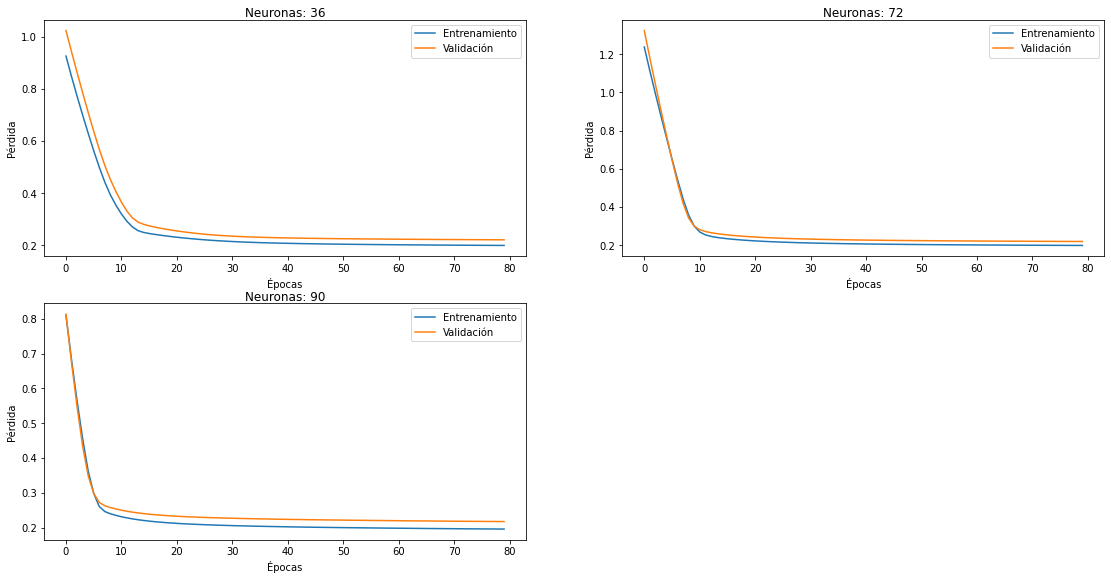

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Neuronas: '+str(neurons[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

In [ ]:
nombreModelo= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_trivariada_Smoteen_VariaNeuronas_Modelo"

#-------- GUARDA LOS MODELOS --------

In [ ]:
# serializa el modelo para JSON
for i in range(cantidad_modelos):
  model_json = models[i].to_json()
  with open(nombreModelo+str(i)+".json", "w") as json_file:
    json_file.write(model_json)
  #serializan los pesos (weights) para HDF5
  models[i].save_weights(nombreModelo+str(i)+".h5")
  # guarda el history
  histories[i].to_csv(nombreModelo+'history_'+str(i)+'.csv',  index = False, header=True)  

print("Modelos guardado en el PC")
json_file.close()

Modelos guardado en el PC


# **Recuperar los modelos**

In [ ]:
# carga el json y crea el modelo
models=[]
histories=[]

for i in range(cantidad_modelos):
  json_file = open(nombreModelo+str(i)+".json", 'r')
  loaded_model_json = json_file.read()  
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # se cargan los pesos (weights) en el nuevo modelo
  loaded_model.load_weights(nombreModelo+str(i)+".h5")
  models.append(loaded_model)
  # recupero el loss (mse) y el error (mae) de entrenamiento
  histories.append(pd.read_csv(nombreModelo+'history_'+str(i)+'.csv'))  

print("Modelos recuperados en el PC")

Modelos recuperados en el PC


#Evaluación y Predicción

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  m1_testPredict = models[i].predict(testX_scaler)
  m1_testPredict = np.asarray(m1_testPredict).reshape(-1,1)
  m_testPredict_scaled.append(m1_testPredict)
  m1_testPredict = scalerY.inverse_transform(m1_testPredict)
  m_testPredict.append(m1_testPredict) 

In [ ]:
 #obtiene el error de cada modelo para el conjunto de datos de test
error_prediction=[]
error_prediction_scaled=[]
for i in range(cantidad_modelos):    
  error_prediction_scaled.append(testY_scaler.reshape(1,-1)[0] - m_testPredict_scaled[i][:,0])
  error_prediction.append(ytest.to_numpy().reshape(1,-1)[0] - m_testPredict[i][:,0])

In [ ]:
print('mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test')
for i in range(cantidad_modelos):
  trainpred= models[i].predict(trainX_scaler)  
  valpred= models[i].predict(validationX_scaler)  

  msetrain= mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  
  mseval =  mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))  
  msetest=  mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]) 

  rmsetrain= sqrt(mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  )
  rmseval=  sqrt(mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))) 
  rmsetest= sqrt(mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]))
  
  r2train= r2_score(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))
  r2val=   r2_score(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))
  r2test= r2_score(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0])

  print('{:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} '.format(msetrain, mseval, msetest, rmsetrain, rmseval,rmsetest, r2train, r2val, r2test))
  

mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test
   6.094    6.756    6.598    2.469    2.599    2.569    0.807    0.802    0.667 
   6.084    6.719    6.624    2.467    2.592    2.574    0.808    0.803    0.666 
   5.992    6.654    6.570    2.448    2.580    2.563    0.811    0.805    0.669 


In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1

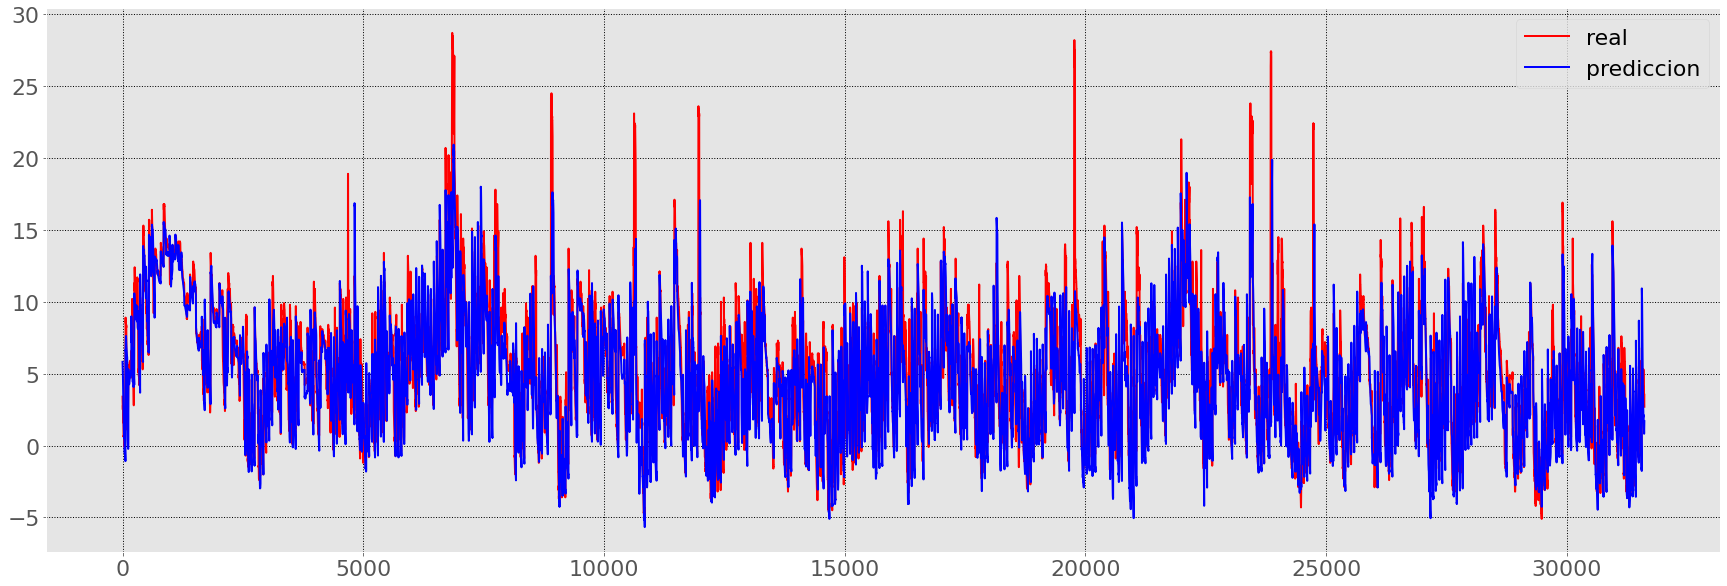

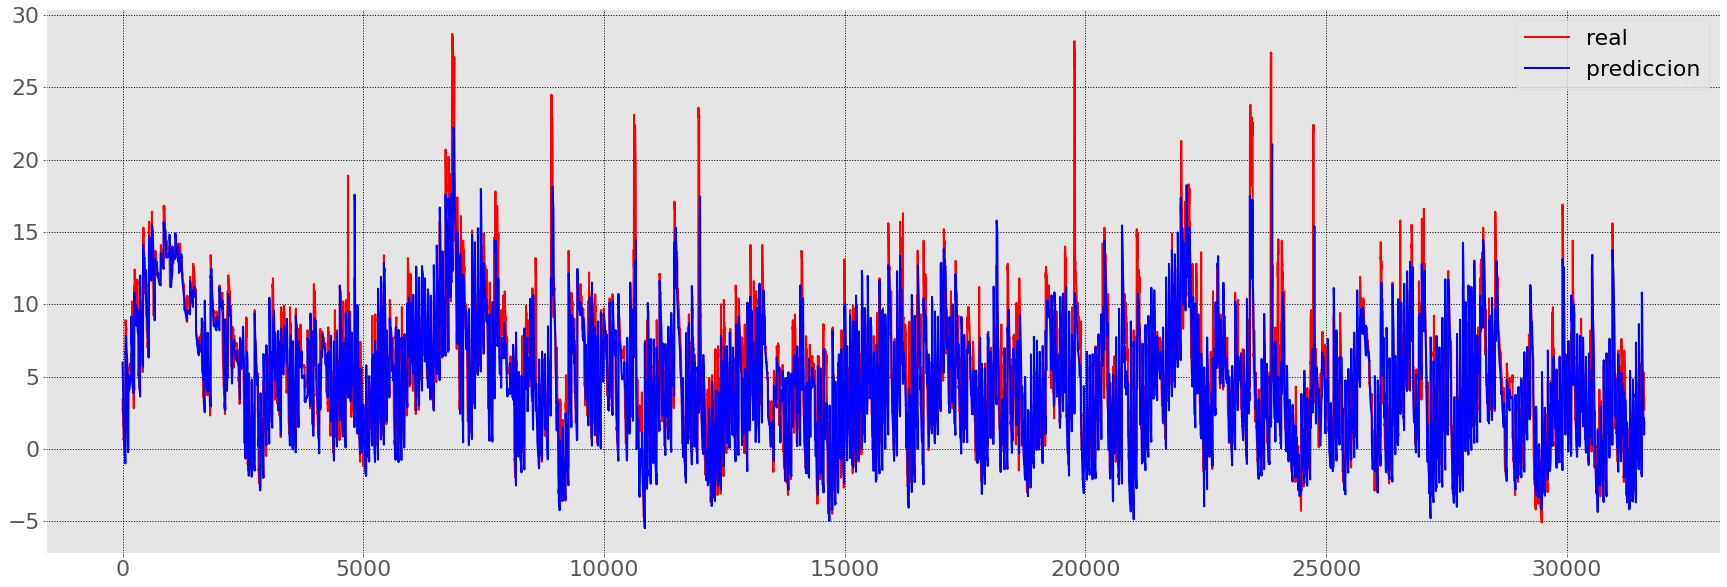

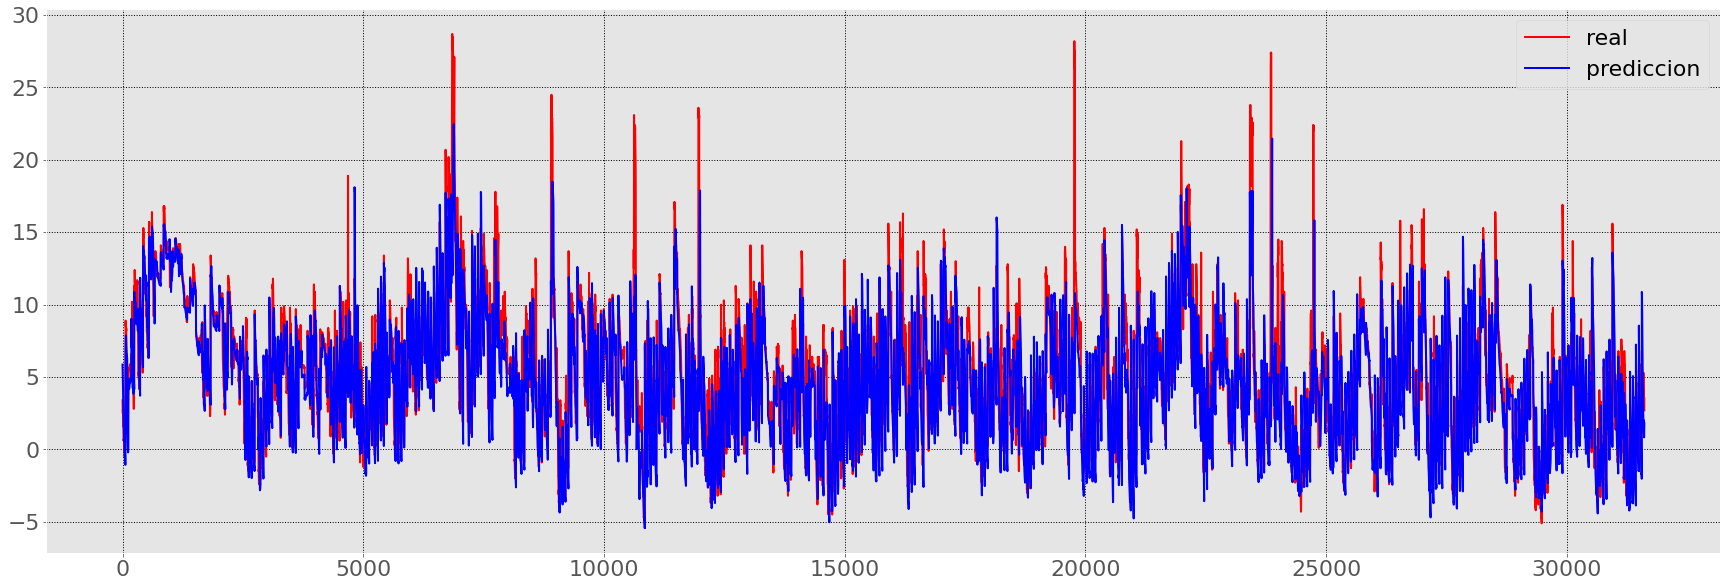

In [ ]:
for i in range(cantidad_modelos):
  plt.plot(ytest.to_numpy().reshape(1,-1)[0], color= "red", label="real")
  plt.plot(m_testPredict[i][:,0], color= "blue", label="prediccion")
  #plt.plot(error_prediction[i], color='green', label= 'error')
  plt.legend()
  plt.show()

#Helada

In [ ]:
index= ytest <= 0
ty= ytest[index]
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  print('MSE: %.4f ' % (mean_squared_error(ty, py, squared= True)))

MSE: 2.2779 
MSE: 2.2074 
MSE: 2.2221 


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("precision{:7.3f}".format(accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 
  i+=1

precision  0.917
[[ 2830   930]
 [ 1691 26162]]
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      3760
           1       0.97      0.94      0.95     27853

    accuracy                           0.92     31613
   macro avg       0.80      0.85      0.82     31613
weighted avg       0.93      0.92      0.92     31613

precision  0.918
[[ 2884   876]
 [ 1713 26140]]
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      3760
           1       0.97      0.94      0.95     27853

    accuracy                           0.92     31613
   macro avg       0.80      0.85      0.82     31613
weighted avg       0.93      0.92      0.92     31613

precision  0.917
[[ 2901   859]
 [ 1757 26096]]
              precision    recall  f1-score   support

           0       0.62      0.77      0.69      3760
           1       0.97      0.94      0.95     27853

    accuracy                          

In [ ]:
py= m_testPredict[0][index]
#diferencia= ty - py
yreales= ty.to_numpy()
ypredichos= py.reshape(-1)
print(yreales)
print(ypredichos)

[-0.1  0.  -0.2 ... -0.4 -0.3 -0.2]
[ 0.2830976   0.3380309   0.12420972 ... -1.5096208  -1.6324474
 -1.6231319 ]


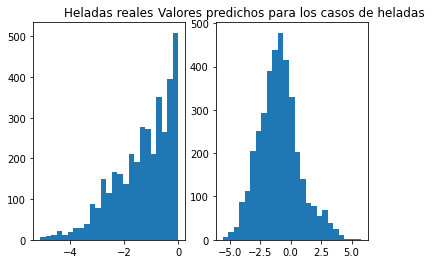

In [ ]:
plt.subplot(1,2,1)
#plt.figure(figsize=(10,5))
plt.hist(yreales, bins=25)
plt.title('Heladas reales')

plt.subplot(1,2,2)
plt.hist(ypredichos, bins=25)
plt.title('Valores predichos para los casos de heladas')
plt.show()


In [ ]:
diferencia= yreales - ypredichos
print(min(diferencia), max(diferencia))

-5.966082763671875 4.383783626556396


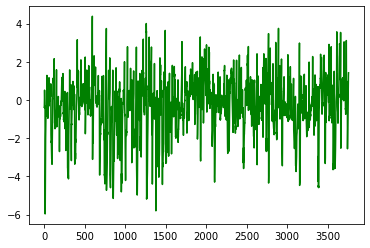

In [ ]:
 plt.plot(diferencia, color= "green", label="Error")
 plt.show()

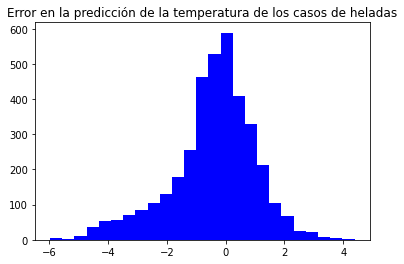

In [ ]:
plt.hist(diferencia, bins=25,color = "blue")
plt.title('Error en la predicción de la temperatura de los casos de heladas')
plt.show()

In [ ]:
predicciones_menores= yreales > ypredichos
#predicciones_mayores= yreales < ypredichos
#ocurrencias = dict((i, predicciones_menores.count(i)) for i in predicciones_menores)
print(predicciones_menores)
import collections

counter = collections.Counter(predicciones_menores)
print(counter)

[False False False ...  True  True  True]
Counter({False: 2229, True: 1531})


In [ ]:
#indices de las healdas tardias en el conjunto de test
index_heladas_tardias= (df_test['Y']<=0) & (df_test.DateTime.dt.month >=8)
pytardia= m_testPredict[0][index_heladas_tardias]

In [ ]:
# todas las heladas tardías del conjunto de test
df_heladas_tardias= df_test[(df_test.DateTime.dt.month >=8) & (df_test['Y'] <=0)]


In [ ]:
heladas_tardias= ytest[index_heladas_tardias]
for i in range(cantidad_modelos):
  pytardia= m_testPredict[i][index_heladas_tardias]
  print('MSE: %.4f ' % (mean_squared_error(pytardia, heladas_tardias, squared= True)))

MSE: 2.5699 
MSE: 2.3296 
MSE: 2.3357 


In [ ]:
f_es_helada_tardia = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real_tardia = list(map(f_es_helada_tardia, heladas_tardias))
  binario_pred_tardia = list(map(f_es_helada_tardia, m_testPredict[i][index_heladas_tardias]))
  print("precision{:7.3f}".format(accuracy_score(binario_real_tardia, binario_pred_tardia)) )
  print(confusion_matrix(binario_real_tardia, binario_pred_tardia))
  print(classification_report(binario_real_tardia, binario_pred_tardia)) 
  i+=1

precision  0.741
[[531 186]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       717
           1       0.00      0.00      0.00         0

    accuracy                           0.74       717
   macro avg       0.50      0.37      0.43       717
weighted avg       1.00      0.74      0.85       717

precision  0.757
[[543 174]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       717
           1       0.00      0.00      0.00         0

    accuracy                           0.76       717
   macro avg       0.50      0.38      0.43       717
weighted avg       1.00      0.76      0.86       717

precision  0.752
[[539 178]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86       717
           1       0.00      0.00      0.00         0

    accuracy                           0.75       717
   macro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

++++++++++++++

In [ ]:
nombreModelo54= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_trivariada_Smoteen_Modelo"

In [ ]:
nombreModelovarias= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_trivariada_Smoteen_VariaNeuronas_Modelo"

In [ ]:
histories=[]
histories.append(pd.read_csv(nombreModelovarias+'history_0.csv'))  
histories.append(pd.read_csv(nombreModelo54+'history_0.csv'))  
histories.append(pd.read_csv(nombreModelovarias+'history_1.csv'))  
histories.append(pd.read_csv(nombreModelovarias+'history_2.csv'))  

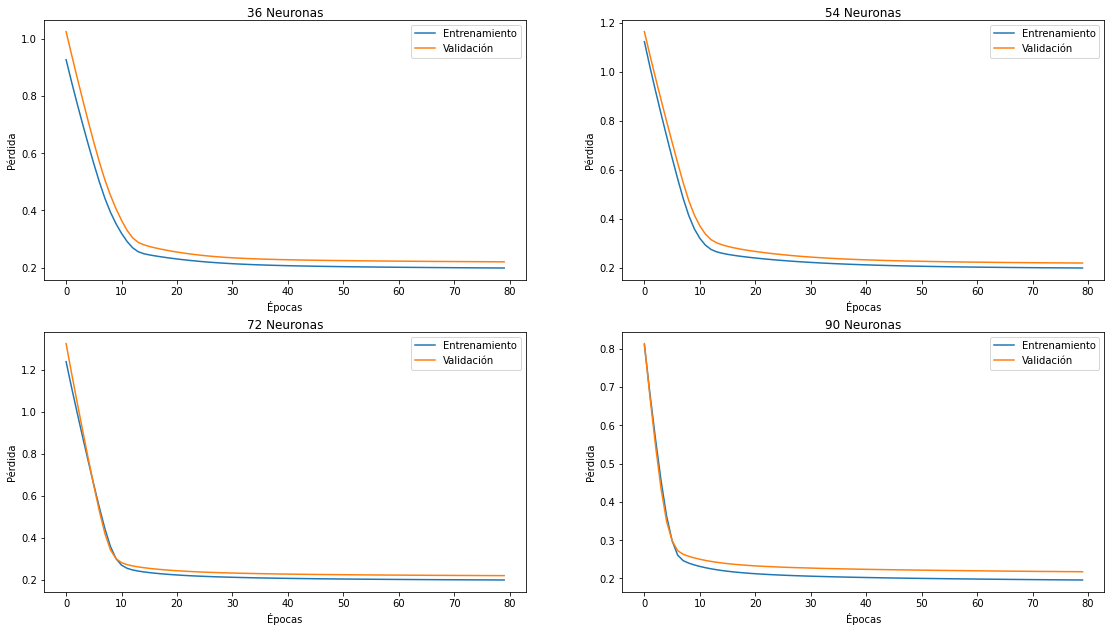

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
neurons=[36,54,72,90]
pyplot.figure(figsize=(19, 22))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title(str(neurons[i])+' Neuronas', pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))